# Download Dataset From Kaggle
[Kaggle Dataset Link](https://www.kaggle.com/datasets/wwymak/architecture-dataset)<br>
Originally from paper: [Architectural Style Classification Using Multinomial Latent Logistic Regression](https://pdfs.semanticscholar.org/0ed0/eb02de7579c714236c480f06faf239f3cd95.pdf)

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

! kaggle datasets download -d wwymak/architecture-dataset

100% 1.43G/1.43G [01:26<00:00, 19.3MB/s]
100% 1.43G/1.43G [01:26<00:00, 17.8MB/s]


In [ ]:
! unzip "architecture-dataset"

# Dataset Setup

In [3]:
import torch
from torchvision import datasets, transforms,  models
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm

In [4]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
fpath = './arcDataset'
IMG_SIZE = 256
transformations = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),\
                                      transforms.ToTensor()]
                                     )

image_dataset = datasets.ImageFolder(fpath, transform=transformations)

Train/Dev/Test Split

In [6]:
# Define the split ratios (70% train, 15% dev, 15% test)
total_count = len(image_dataset)
train_count = int(0.7 * total_count)
dev_count = int(0.15 * total_count)
test_count = total_count - train_count - dev_count

# Split the dataset
train_indices, valid_indices, test_indices = torch.utils.data.random_split(
    range(total_count), [train_count, dev_count, test_count]
)

# Create custom Subset classes with different transforms
train_dataset = Subset(image_dataset, train_indices)
dev_dataset = Subset(image_dataset, valid_indices)
test_dataset = Subset(image_dataset, test_indices)

In [7]:
# Create data loaders
BATCH_SIZE = 32
NUM_WORKER = 2
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKER)

In [8]:
class_names = {idx: cls for cls, idx in train_loader.dataset.dataset.class_to_idx.items()}
classes = train_loader.dataset.dataset.classes
print(f'Batch Size: {train_loader.batch_size}')
print(f'Images Count (per batch): {len(train_loader)}')
print(f'Total Images Count (train set): {len(train_loader.dataset)}')
print(f'Total Images Count (dev set): {len(dev_loader.dataset)}')
print(f'Total Images Count (test set): {len(test_loader.dataset)}')
print(f'Total Classes: {len(classes)}')
classes

Batch Size: 32
Images Count (per batch): 105
Total Images Count (train set): 3355
Total Images Count (dev set): 719
Total Images Count (test set): 720
Total Classes: 25


['Achaemenid architecture',
 'American Foursquare architecture',
 'American craftsman style',
 'Ancient Egyptian architecture',
 'Art Deco architecture',
 'Art Nouveau architecture',
 'Baroque architecture',
 'Bauhaus architecture',
 'Beaux-Arts architecture',
 'Byzantine architecture',
 'Chicago school architecture',
 'Colonial architecture',
 'Deconstructivism',
 'Edwardian architecture',
 'Georgian architecture',
 'Gothic architecture',
 'Greek Revival architecture',
 'International style',
 'Novelty architecture',
 'Palladian architecture',
 'Postmodern architecture',
 'Queen Anne architecture',
 'Romanesque architecture',
 'Russian Revival architecture',
 'Tudor Revival architecture']

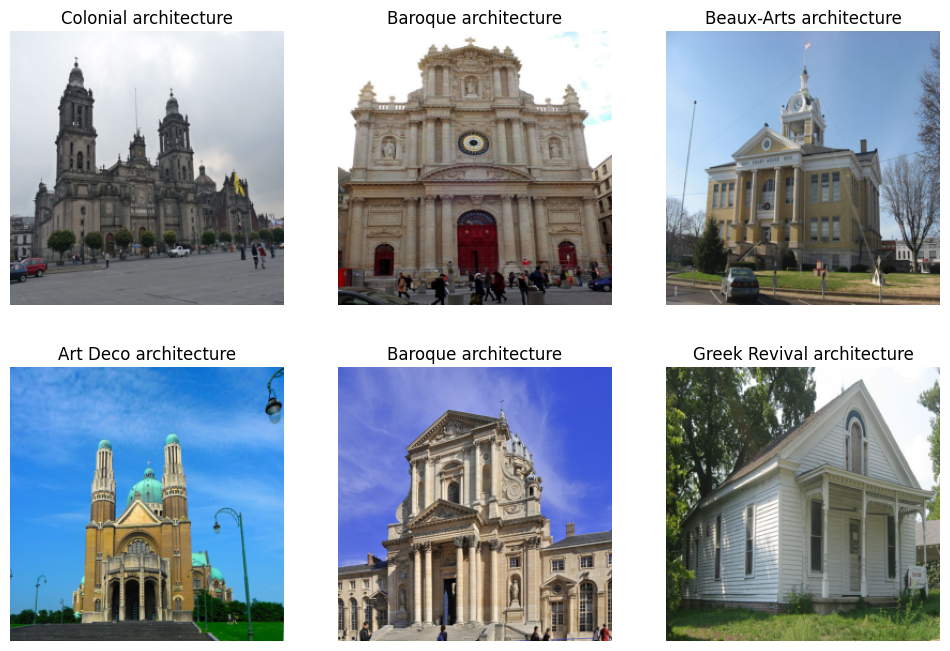

In [9]:
figure = plt.figure(figsize=(12, 8))
num_of_images = 6
images, labels = next(iter(train_loader))

for i in range(1, num_of_images + 1):
    index = int(torch.randint(low=0, high=len(images), size=(1,))[0])
    plt.subplot(2, 3, i)
    plt.axis('off')
    plt.imshow(images[index].permute(1, 2, 0))
    plt.title(f'{classes[labels[index]]}')

Visualize Count Distribution for Train/Dev/Test Images

In [10]:
# Get the class labels (targets) for both train and test datasets
train_labels = [label for _, label in tqdm(train_dataset)]
dev_labels =  [label for _, label in tqdm(dev_dataset)]
test_labels = [label for _, label in tqdm(test_dataset)]

  0%|          | 0/3355 [00:00<?, ?it/s]

  0%|          | 0/719 [00:00<?, ?it/s]

  0%|          | 0/720 [00:00<?, ?it/s]

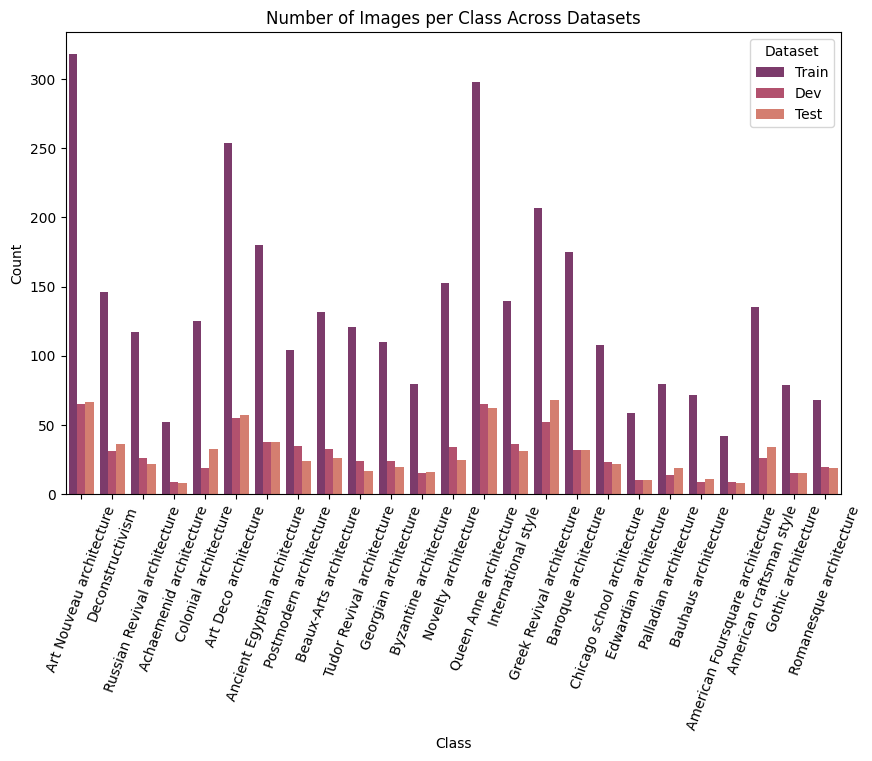

In [11]:
# Count the occurrences of each class label
train_class_counts = dict(Counter(train_labels))
dev_class_counts = dict(Counter(dev_labels))
test_class_counts = dict(Counter(test_labels))

# Prepare the count dataframe for visualization
data = []
for dataset_name, class_counts in [("Train", train_class_counts), ("Dev", dev_class_counts), ("Test", test_class_counts)]:
    for class_label, count in class_counts.items():
        data.append({"Dataset": dataset_name, "Class": classes[class_label], "Count": count})

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="Class", y="Count", hue="Dataset", data=df, palette='flare_r')
plt.title("Number of Images per Class Across Datasets")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=70)
plt.legend(title="Dataset")
plt.show()

# Feature Extraction Model (ResNet50)

In [14]:
model = models.resnet50(weights=True).cuda()
summary(model, input_size = (3, IMG_SIZE, IMG_SIZE))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [17]:
# remove last fully-connected layer
feature_extractor = nn.Sequential(*list(model.children())[:-1])
# Check if it works
x = torch.randn([1, 3, IMG_SIZE, IMG_SIZE]).cuda()
output = feature_extractor(x)
# Should be (1, 2048, 1, 1)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 2048, 1, 1])


In [20]:
# summary(feature_extractor, input_size = (3, IMG_SIZE, IMG_SIZE))

In [ ]:
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER)
# all_dataloader = [train_loader, dev_loader, test_loader]

# train_labels
# dev_labels
# test_labels

In [21]:
all_dataloaders = {
                    'train': train_loader,
                    'dev': dev_loader,
                    'test': test_loader
                   }

Generate PreTrained Features

In [25]:
feature_extractor.eval()
feature_extractor = feature_extractor.cuda()

# no gradient calculation for inference only
with torch.no_grad():
  features = {}
  image_labels = {}

  # loop over train/dev/test data loaders
  for loader_type, dataloader in all_dataloaders.items():
    features[loader_type] = None
    image_labels[loader_type] = None
    print(f'Running {loader_type} loader for {len(dataloader)} batches...')

    # loop over every batch for each dataloader
    for data, label in tqdm(dataloader):
      x = data.cuda()
      output = feature_extractor(x)

      if features[loader_type] is not None:
        features[loader_type] = torch.cat((features[loader_type], output), 0)
        image_labels[loader_type] = torch.cat((image_labels[loader_type], label), 0)
      else:
        features[loader_type] = output
        image_labels[loader_type] = label

    features[loader_type] = features[loader_type].view(features[loader_type].size(0), -1)

Running train loader for 105 batches...


  0%|          | 0/105 [00:00<?, ?it/s]

Running dev loader for 23 batches...


  0%|          | 0/23 [00:00<?, ?it/s]

Running test loader for 23 batches...


  0%|          | 0/23 [00:00<?, ?it/s]

In [28]:
print(f"Train loader size: {features['train'].size(0)}")
print(f"Dev loader size: {features['dev'].size(0)}")
print(f"Test loader size: {features['test'].size(0)}")

Train loader size: 3355
Dev loader size: 719
Test loader size: 720


In [29]:
print(f"Train labels shape: {image_labels['train'].shape}")
print(f"Dev labels shape: {image_labels['dev'].shape}")
print(f"Test labels shape: {image_labels['test'].shape}")

Train labels shape: torch.Size([3355])
Dev labels shape: torch.Size([719])
Test labels shape: torch.Size([720])


In [31]:
print(f"Train feature length: {features['train'][0].shape}")
print(f"Dev feature length: {features['dev'][0].shape}")
print(f"Test feature length: {features['test'][0].shape}")

Train feature length: torch.Size([2048])
Dev feature length: torch.Size([2048])
Test feature length: torch.Size([2048])


# Train Model on Feature Extraction Vectors

## Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
features_np = dict()
image_labels_np = dict()

# convert torch tensors to numpy arrays
for loader_type in tqdm(all_dataloaders.keys()):
  features_np[loader_type] = features[loader_type].cpu().numpy()
  image_labels_np[loader_type] = image_labels[loader_type].cpu().numpy()

  0%|          | 0/3 [00:00<?, ?it/s]

In [36]:
X_train, y_train = features_np['train'], image_labels_np['train']
print(f"Train Dataset:\nImage count: {len(y_train)}\tFeature length: {len(X_train[0])}\n")

X_dev, y_dev = features_np['dev'], image_labels_np['dev']
print(f"Dev Dataset:\nImage count: {len(y_dev)}\tFeature length: {len(X_dev[0])}\n")

X_test, y_test = features_np['test'], image_labels_np['test']
print(f"Test Dataset:\nImage count: {len(y_test)}\tFeature length: {len(X_test[0])}\n")

Train Dataset:
Image count: 3355	Feature length: 2048

Dev Dataset:
Image count: 719	Feature length: 2048

Test Dataset:
Image count: 720	Feature length: 2048



In [46]:
model_lr = LogisticRegression(C=0.1, max_iter=300)
model_lr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1, max_iter=300)

Predict Labels

In [51]:
y_pred_train = model_lr.predict(X_train)
y_pred_dev = model_lr.predict(X_dev)
y_pred_test = model_lr.predict(X_test)

In [58]:
lr_perf = dict()
lr_perf['train'] = dict()
lr_perf['dev'] = dict()
lr_perf['test'] = dict()

lr_perf['train']['accuracy_score'] = accuracy_score(y_train, y_pred_train)
lr_perf['train']['recall_score'] = recall_score(y_train, y_pred_train, average='weighted')
lr_perf['train']['precision_score'] = precision_score(y_train, y_pred_train, average='weighted')
lr_perf['train']['f1_score'] = f1_score(y_train, y_pred_train, average='weighted')

lr_perf['dev']['accuracy_score'] = accuracy_score(y_dev, y_pred_dev)
lr_perf['dev']['recall_score'] = recall_score(y_dev, y_pred_dev, average='weighted')
lr_perf['dev']['precision_score'] = precision_score(y_dev, y_pred_dev, average='weighted')
lr_perf['dev']['f1_score'] = f1_score(y_dev, y_pred_dev, average='weighted')

lr_perf['test']['accuracy_score'] = accuracy_score(y_test, y_pred_test)
lr_perf['test']['recall_score'] = recall_score(y_test, y_pred_test, average='weighted')
lr_perf['test']['precision_score'] = precision_score(y_test, y_pred_test, average='weighted')
lr_perf['test']['f1_score'] = f1_score(y_test, y_pred_test, average='weighted')

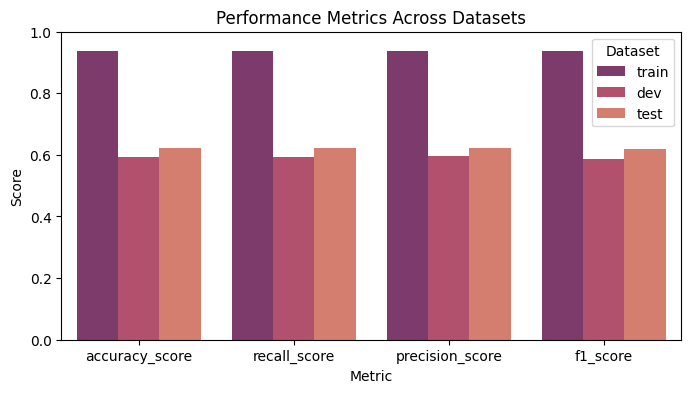

In [141]:
df = pd.DataFrame(lr_perf)

# Reshape the DataFrame
df_melted = df.reset_index().melt(id_vars='index', value_vars=['train', 'dev', 'test'])
df_melted = df_melted.rename(columns={'index': 'Metric', 'variable': 'Dataset', 'value': 'Score'})

# Plotting
plt.figure(figsize=(8, 4))
sns.barplot(x='Metric', y='Score', hue='Dataset', data=df_melted, palette='flare_r')
plt.title("Performance Metrics Across Datasets")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.ylim(0, 1)  # Adjust the y-axis to fit the score range
plt.legend(title="Dataset", loc='upper right')
plt.show()

Text(0.5, 1.0, 'Classification Report (Train)')

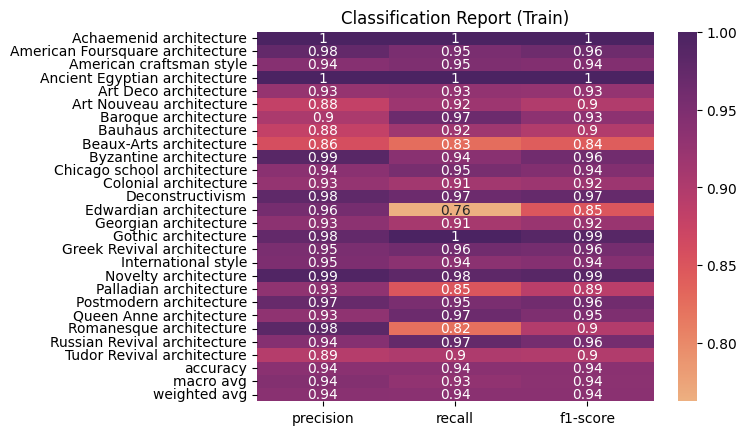

In [166]:
cr = classification_report(y_train, y_pred_train, target_names=classes, output_dict=True)
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, yticklabels=cr.keys(), cmap='flare', annot=True)
plt.title('Classification Report (Train)')

Text(0.5, 1.0, 'Classification Report (Dev)')

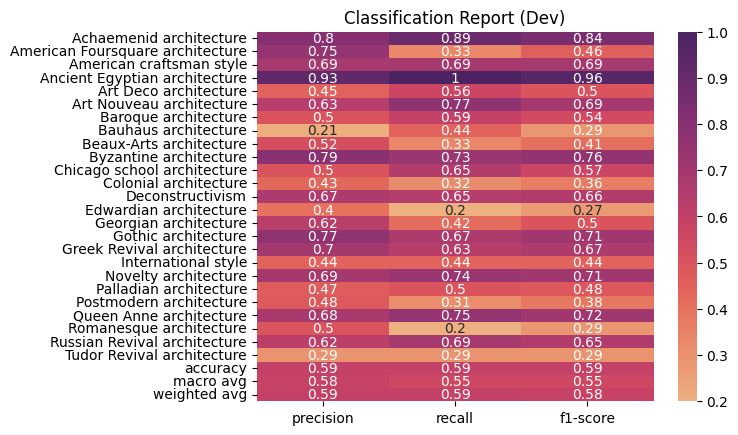

In [167]:
cr = classification_report(y_dev, y_pred_dev, target_names=classes, output_dict=True)
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, yticklabels=cr.keys(), cmap='flare', annot=True)
plt.title('Classification Report (Dev)')

Text(0.5, 1.0, 'Classification Report (Test)')

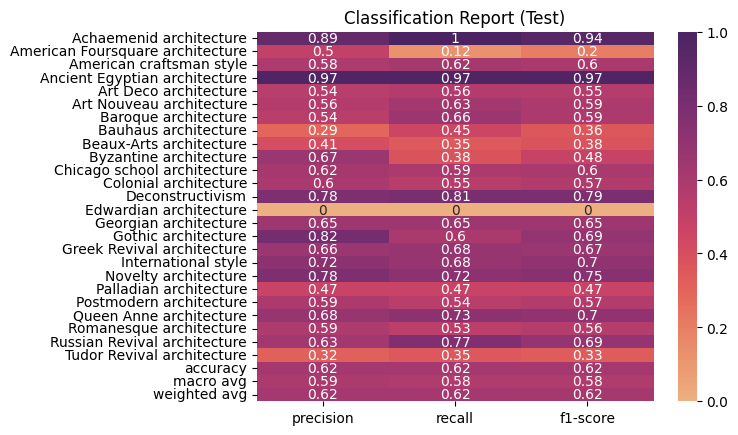

In [168]:
cr = classification_report(y_test, y_pred_test, target_names=classes, output_dict=True)
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, yticklabels=cr.keys(), cmap='flare', annot=True)
plt.title('Classification Report (Test)')

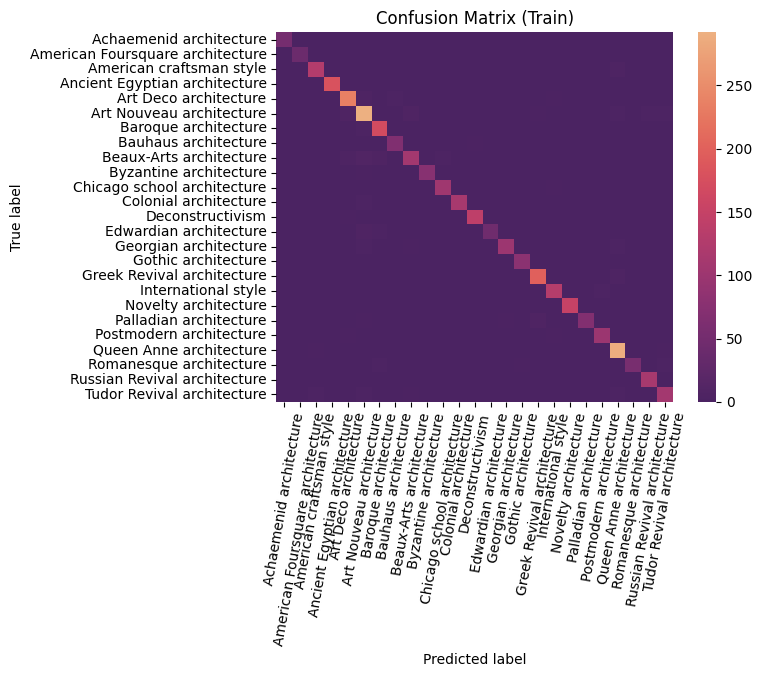

In [169]:
sns.heatmap(confusion_matrix(y_train, y_pred_train), xticklabels=classes, yticklabels=classes, cmap='flare_r')
plt.xticks(rotation=80)
plt.title("Confusion Matrix (Train)")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

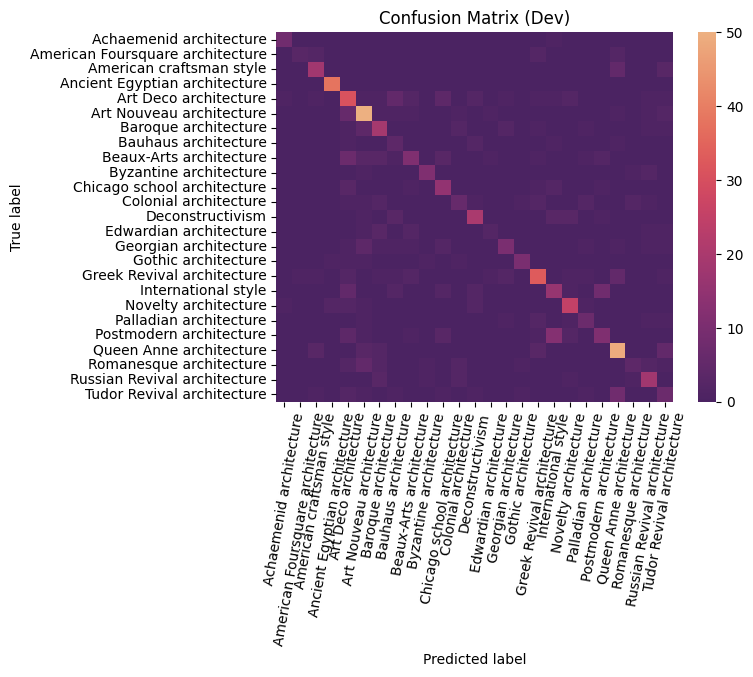

In [170]:
sns.heatmap(confusion_matrix(y_dev, y_pred_dev), xticklabels=classes, yticklabels=classes, cmap='flare_r')
plt.xticks(rotation=80)
plt.title("Confusion Matrix (Dev)")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

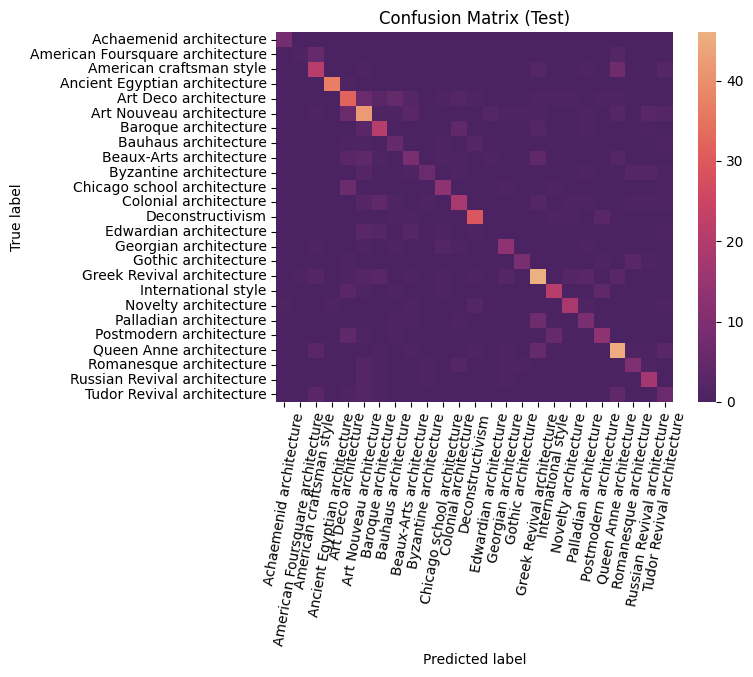

In [171]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), xticklabels=classes, yticklabels=classes, cmap='flare_r')
plt.xticks(rotation=80)
plt.title("Confusion Matrix (Test)")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()